In [7]:
import torch.nn as nn
import torch
import torchvision
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import torch.optim as optim

In [4]:
transform=transforms.ToTensor()
train_set=datasets.MNIST(root="data",train=True,transform=transform,target_transform=None,download=True)
test_set=datasets.MNIST(root="data",train=False,transform=transform,target_transform=None,download=True)


train_loader=DataLoader(train_set,batch_size=64,shuffle=True)
test_loader=DataLoader(test_set,batch_size=64,shuffle=False)

100.0%
100.0%
100.0%
100.0%


In [5]:

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # MNIST: 1 channel
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32*7*7, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))    # 28x28x16
        x = self.pool(x)             # 14x14x16
        x = F.relu(self.conv2(x))    # 14x14x32
        x = self.pool(x)             # 7x7x32
        x = x.view(-1, 32*7*7)       # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN()
print(model)


SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Lists to store metrics for each epoch
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
num_epochs = 5

for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()  # Set the model to training mode
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update metrics for this batch
        running_train_loss += loss.item()
        total_train += labels.size(0)
        _, predicted = outputs.max(1)
        correct_train += (predicted == labels).sum().item()
    
    # Calculate average loss and accuracy for the training epoch
    epoch_train_loss = running_train_loss / len(train_loader)
    epoch_train_accuracy = correct_train / total_train
    
    # Append to the lists
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # --- Validation Phase ---
    model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    # No gradient calculation is needed during validation
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass only
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Update metrics for this batch
            running_val_loss += loss.item()
            total_val += labels.size(0)
            _, predicted = outputs.max(1)
            correct_val += (predicted == labels).sum().item()

    # Calculate average loss and accuracy for the validation epoch
    epoch_val_loss = running_val_loss / len(test_loader)
    epoch_val_accuracy = correct_val / total_val
    
    # Append to the lists
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)
    
    # Print the results for the current epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.4f}")

Epoch [1/5], Train Loss: 0.2393, Train Acc: 0.9276, Val Loss: 0.0681, Val Acc: 0.9773
Epoch [2/5], Train Loss: 0.0620, Train Acc: 0.9811, Val Loss: 0.0462, Val Acc: 0.9849
Epoch [3/5], Train Loss: 0.0444, Train Acc: 0.9859, Val Loss: 0.0483, Val Acc: 0.9851
Epoch [4/5], Train Loss: 0.0333, Train Acc: 0.9898, Val Loss: 0.0547, Val Acc: 0.9814
Epoch [5/5], Train Loss: 0.0261, Train Acc: 0.9917, Val Loss: 0.0304, Val Acc: 0.9906


torch.Size([16, 1, 3, 3])


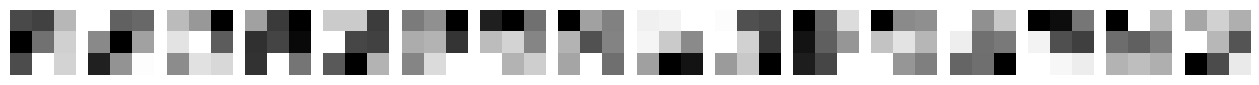

In [18]:
import matplotlib.pyplot as plt

# Take first conv layer
filters = model.conv1.weight.data.cpu()

print(filters.shape)  # e.g., (16, 1, 3, 3) for MNIST

fig, axes = plt.subplots(1, 16, figsize=(16, 2))
for i, ax in enumerate(axes):
    ax.imshow(filters[i, 0, :, :], cmap='gray')  # first channel
    ax.axis('off')
plt.show()



In [19]:
import matplotlib.pyplot as plt

# Pick one image from dataloader
images, labels = next(iter(val_loader))
img = images[0].unsqueeze(0).to(device)  # add batch dimension

# Forward pass manually
x = F.relu(model.conv1(img))  # first conv layer
x_pool = model.pool(x)        # after pooling


NameError: name 'val_loader' is not defined